 # Fraud Credit Card Project w/ manual sub-sampling
 
Markus Proesch

July 10th, 2020
 
 ### Context and data
Credit Card fraud happens every day and as consumers we put the responsibility on the credit card provider to keep our cards and money safe. For credit card companies it is important to be able to recognize fraudulent credit card transactions in order to reject them, but at the same time rejecting a transaction that is not-fraudulent can result in unsatisfied customer and potentially loss of that client. It's a fine line!
 
The dataset I have worked with contains transactions made by credit cards in September 2013 by european cardholders. The dataset presents transactions that occurred in two days, where 492 are fraudulent out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

### Additional information
The dataset contains only numerical input variables which are the result of a PCA transformation. Even the feature/variable names have been deleted due to confidentiality issues. The only 2 features that have not been standardized are "Time" and "Amount". The "Time" feature is given in seconds from the first transaction of day one. 

### The job
The task is to develop a model that can recognize/predict if a transaction is fraud (1) or not fraud (0). I will not be using the Near Miss under-sampling technique or the SMOTE over-sampling technique to balance the dataset. Those will most likely be featured in a later project. 

### Outline
1.  Upload document and explore data
2.  Preprocessing (scaling Time and Amount)
3.  Re-sample imbalanced dataset (50/50 split)
4.  Remove extreme outliers 
5.  Train-Test split 
6.  Hyperparameter tuning
7.  Build the model with Train set
8.  Test the model with Test set
9.  Test model on original dataset
10.  Adjust probability threshold 

## Loading all the libraries and dependencies required

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, accuracy_score, 
                             confusion_matrix, classification_report,
                             precision_recall_curve)

from sklearn.preprocessing import RobustScaler
from sklearn.utils import shuffle

from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier 
from sklearn.svm import SVC

## Importing and Understand the data
The first thing I do when I start a new project is to try and familiarize myself with the dataset and look at the meta data. I also check for missing and odd values. Next, I check for skewness in each variable and try to make sense of the data for myself. Investigating the data and cleaning it is often what I end up spending the most time doing. In this case however the data provided is clean and the distribution seems to be relatively normal, expect for the "Class" variable, but more on that later.

In [2]:
file = 'bq-results-20200623-183427-61x6wu1btjaq.csv'
df = pd.read_csv(file, header = 0)


df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.576557e-15,-1.569892e-15,-1.010518e-15,3.797180e-15,4.915559e-16,1.439309e-15,-8.650479e-16,8.763491e-17,-2.791778e-15,...,2.431282e-18,1.626819e-17,-2.970945e-16,4.443599e-15,2.661631e-16,1.754763e-15,-3.840228e-16,-1.165655e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Preprocessing 
### Scale "Time" & "Amount" variables 
The features "Time" and "Amount" was not scaled in the PCA transformation, meaning that they are in their original form and should be scaled like the other variables.

I use RobustScaler() as I have found it more effective against outliers

In [3]:
need_scale = df.loc[:,['Time', 'Amount']]

scaler = RobustScaler()
scaler.fit(need_scale)
var_scaled = scaler.transform(need_scale)

time_amount = pd.DataFrame(var_scaled)

df.loc[:, 'Time'] = time_amount.iloc[:, 0]
df.loc[:, 'Amount'] = time_amount.iloc[:, 1]
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.991670,-0.356466,0.725418,1.971749,0.831343,0.369681,-0.107776,0.751610,-0.120166,-0.420675,...,0.020804,0.424312,-0.015989,0.466754,-0.809962,0.657334,-0.043150,-0.046401,-0.307413,0
1,-0.990519,-1.299837,0.881817,1.452842,-1.293698,-0.025105,-1.170103,0.861610,-0.193934,0.592001,...,-0.272563,-0.360853,0.223911,0.598930,-0.397705,0.637141,0.234872,0.021379,-0.307413,0
2,-0.990249,1.237413,0.512365,0.687746,1.693872,-0.236323,-0.650232,0.118066,-0.230545,-0.808523,...,-0.077543,-0.178220,0.038722,0.471218,0.289249,0.871803,-0.066884,0.012986,-0.307413,0
3,-0.989932,-1.860258,-0.629859,0.966570,0.844632,0.759983,-1.481173,-0.509681,0.540722,-0.733623,...,0.268028,0.125515,-0.225029,0.586664,-0.031598,0.570168,-0.043007,-0.223739,-0.307413,0
4,-0.986630,-0.431349,1.027694,2.670816,2.084787,-0.274567,0.286856,0.152110,0.200872,-0.596505,...,0.001241,0.154170,-0.141533,0.384610,-0.147132,-0.087100,0.101117,0.077944,-0.307413,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,0.821285,0.667714,3.041502,-5.845112,5.967587,0.213863,-1.462923,-2.688761,0.677764,-3.447596,...,0.329760,-0.941383,-0.006075,-0.958925,0.239298,-0.067356,0.821048,0.426175,-0.213233,1
284803,0.070302,-2.405580,3.738235,-2.317843,1.367442,0.394001,1.919938,-3.106942,-10.764403,3.353525,...,10.005998,-2.454964,1.684957,0.118263,-1.531380,-0.695308,-0.152502,-0.138866,-0.209739,1
284804,-0.588094,0.333499,1.699873,-2.596561,3.643945,-0.585068,-0.654659,-2.275789,0.675229,-2.042416,...,0.469212,-0.144363,-0.317981,-0.769644,0.807855,0.228164,0.551002,0.305473,-0.042479,1
284805,0.134435,-1.952933,3.541385,-1.310561,5.955664,-1.003993,0.983049,-4.587235,-4.892184,-2.516752,...,-1.998091,1.133706,-0.041461,-0.215379,-0.865599,0.212545,0.532897,0.357892,-0.042479,1


### Random Re-sampling of imbalanced dataset 
As you probably read in the introduction or can see in the graph below, the dataset is extremly unbalanced. Meaning that there are only 1.7% fraudulent transactions which makes it nearly impossible for the algorithm to detect a pattern. We have to create a sub-set that has a more equal distribution between fraudulent and non-fraudulent cases (50/50).

The first thing I did was to establish the total number of Fraud (1) transactions in the entire dataset by using .value_counts().

Second, I extract all the fraudulent transactions (492) before selecting 492 random non-Fraudulent transactions and shuffling them in a sub-set.

And as you can see in the graph below we now have a perfectly balanced sub-set with 492 Fraud (1) cases and 492 non-Fraudulent cases. If we had kept the dataset as it was the model would have been overfitting and assumed that most transactions were non-Fraud, even when they weren't. 

#### Correlation and heatmap
Another issue with the imbalanced is that we lose the impact the individual features has on the final result. The correlation between the result and the features is lost in all the noise. In the heatmaps below you can see how different the correlation is in the full dataset and the balanced sub-set. Even though we don't know what the features stand for it is clear that some features have a bigger impact than others. Imagine if we knew what the features stood for and we could have drawn so many more valuable insights and suggested other factors that might have been even more helpful.

##### Strongest (negative) correlations:
V14 -0.75, V12 -0.69, V10 -0.63

*This means that the higher these features are decreases the probability of the transaction being Fraud (1)



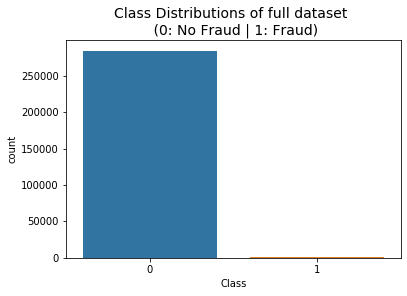

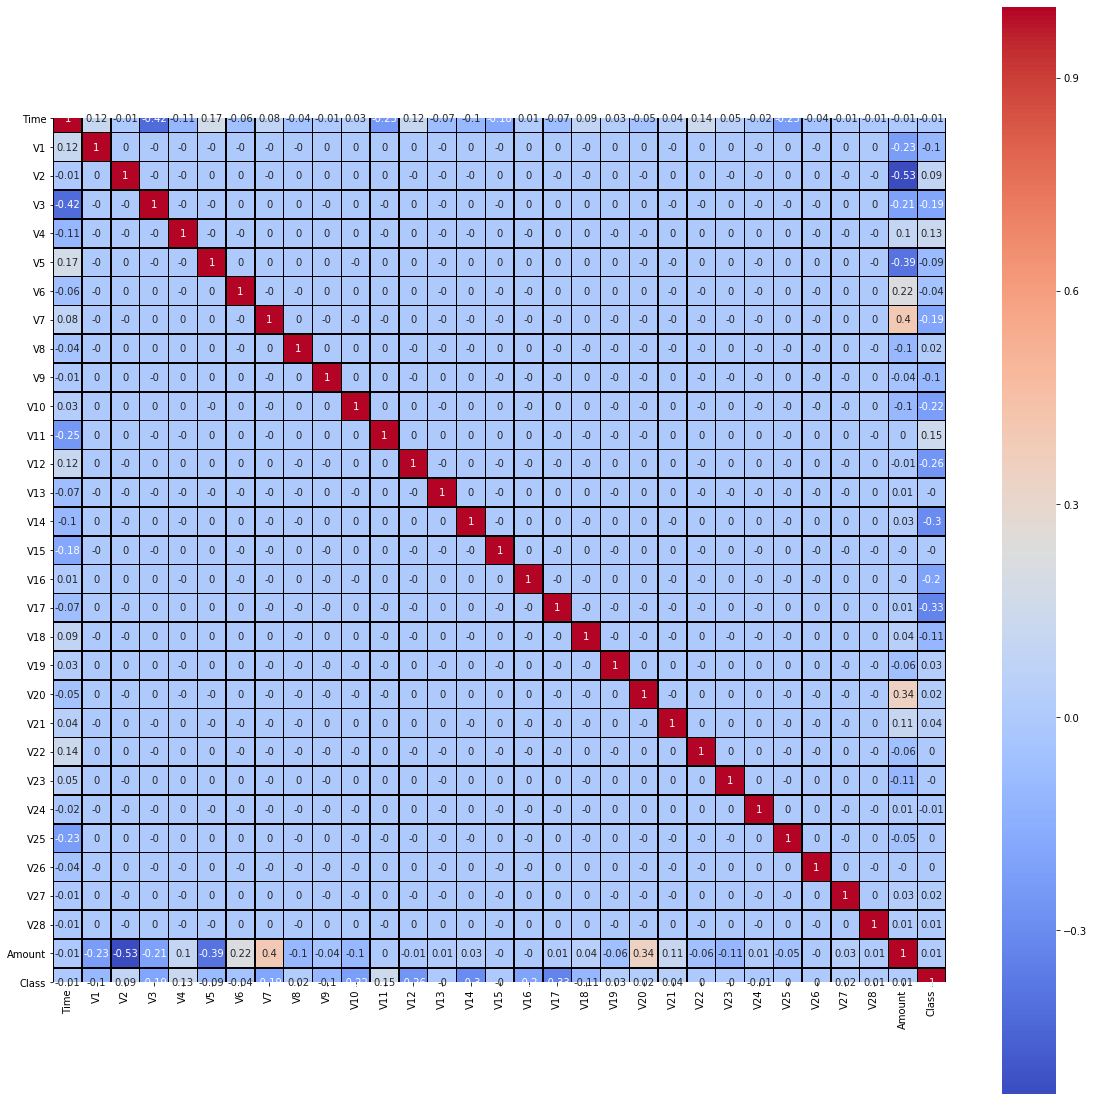

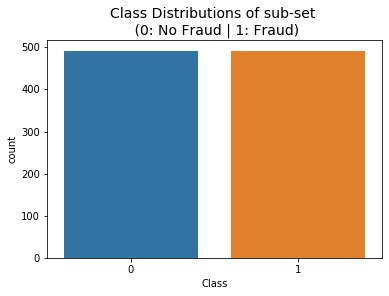

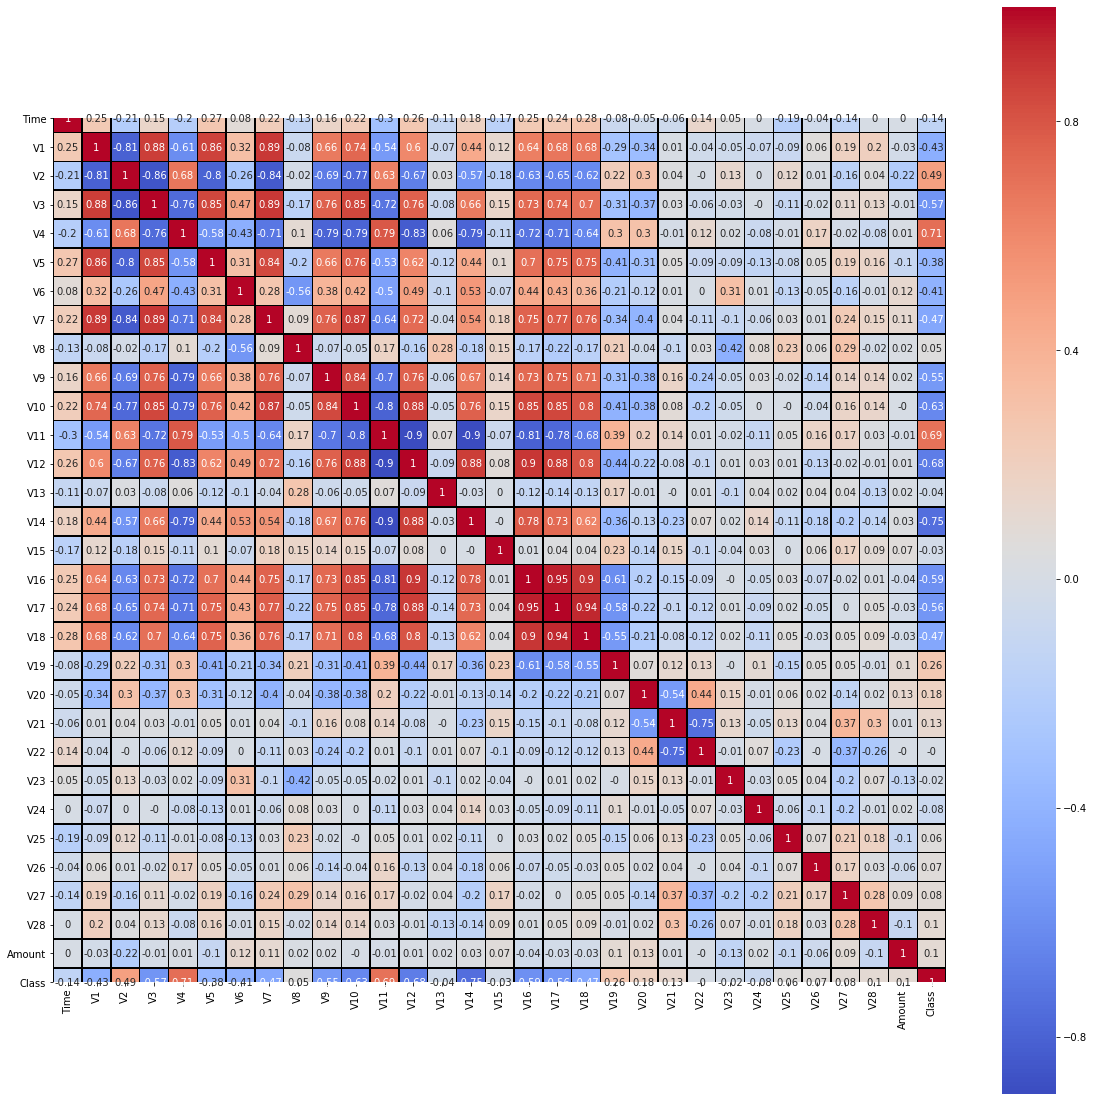

In [4]:
# Frequency plot showing the distribution of Fraud and non-Fraud transactions
sns.countplot('Class', data=df)
plt.title('Class Distributions of full dataset \n (0: No Fraud | 1: Fraud)', 
          fontsize=14)
plt.show()

# Total number of Fraud transactions in the full dataset
df['Class'].value_counts()

# Extract the Fraud transactions where "Class" == 1
class_1 = df.loc[:,:][df['Class'] == 1]

# Extract a random sample of non-Fraud transactions where "Class" == 0
class_0 = df.loc[:,:][df['Class'] == 0].sample(n= 492)

# Concatenate the two datasets and shuffle 
df_sub = pd.concat([class_0, class_1])
df_sub = df_sub.sample(frac=1, random_state=509)



# Heatmap gave a good overview over correlation within the dataset
df_corr = df.corr().round(2)
fig, ax = plt.subplots(figsize  = (20,20))

sns.heatmap(df_corr, cmap = 'coolwarm',
            square = True, annot = True,
            linecolor = 'black', linewidths = 0.5)
plt.show()

# Frequency plot showing the distribution of Fraud and non-Fraud transactions
sns.countplot('Class', data=df_sub)
plt.title('Class Distributions of sub-set \n (0: No Fraud | 1: Fraud)', 
          fontsize=14)
plt.show()


# Heatmap gave a good overview over correlation within the sub-dataset
df_sub_corr = df_sub.corr().round(2)
fig, ax = plt.subplots(figsize  = (20,20))

sns.heatmap(df_sub_corr, cmap = 'coolwarm',
            square = True, annot = True,
            linecolor = 'black', linewidths = 0.5)

### Remove outliers 
As I was exploring the data earlier I noticed that some of the features had some outliers. Usually I am very careful with removing entire records, but when building a classification model like this it can be essential. Looking at the box plots 3 variables stood out to me: V10, V12 and V14. These variables also show high negative correlation with the result so I decided to remove their extreme outliers. 

In order to not lose to much information I decided to go off of the "minimum" value (Q1 - 1.5 * IQR). Basically the lower level of the whiskers. There is definitely a trade-off to where you put your cut off point, if you cut off to much you risk losing crucial information for the model fitting later. 

In [5]:
for index, row in df_sub.iterrows():
    if row['V10'] < -15:
        df_sub.drop(index, inplace = True)

        
for index, row in df_sub.iterrows():
    if row['V12'] < -17:
        df_sub.drop(index, inplace = True)


for index, row in df_sub.iterrows():
    if row['V14'] < -18:
        df_sub.drop(index, inplace = True)


## The Model 

### Train-Test-split dataset
Before we start fitting our model we have to split the data into Train and Test sets. Since the dataset is now balanced I decided to go with a 30/70 split to see how effective my model really was. 

In [6]:
y_variable_full = df.loc[ : ,'Class']
x_variable_full = df.drop(['Class'], axis = 1)

y_variable = df_sub.loc[ : ,'Class']
x_variable = df_sub.drop(['Class'], axis = 1)

# Train / Test split after removing insignificant variables 
X_train, X_test, y_train, y_test = train_test_split(x_variable, y_variable,
                                                   test_size = 0.3,
                                                   stratify = y_variable,
                                                   random_state = 509)

# Build a list to keep track of model values
model_performance = []

model_performance_full = []


### Hyperparameter tuing
If you just want to build a model you don't necessarily have to do this, hyperparameter tuning is essentially choosing a set of optimal hyperparameters for a learning algorithm. It didn't improve my final result all that much and it takes a lot of time, but definitely worth it. Sometimes! 

I decided to use these classifiers:
- Logistic Regression 
- K-Nearest Neighbors Classifier
- Decision Tree Classifier
- Gradient Boosting Classifier
- Random Forest Classifier

In [7]:
## Logistic Regression
LogReg_parameters = {'solver' : ['liblinear', 'lbfgs'] , 'C' : [0.01, 0.1, 1]}

LogReg_grid = GridSearchCV(LogisticRegression(), LogReg_parameters)
LogReg_grid.fit(X_train, y_train)

# Logistic Regression best parameter
LogReg = LogReg_grid.best_estimator_


## K-Nearest Neighbors Classifier
K_Neighbors_parameters = {'n_neighbors' : list(range(1,20,2)),  
                        'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                       'leaf_size' : list(range(5,50,5))}

K_Neighbors_grid = GridSearchCV(KNeighborsClassifier(), K_Neighbors_parameters)
K_Neighbors_grid.fit(X_train, y_train)

#K-Nearest Neighbors best parameter
K_Neighbors = K_Neighbors_grid.best_estimator_


## Decision Tree Classifier
Decision_Tree_parameters = {'criterion': ["gini", "entropy"],
                            'splitter': ["best", "random"]}

DT_grid = GridSearchCV(DecisionTreeClassifier(), Decision_Tree_parameters)
DT_grid.fit(X_train, y_train)

# Decision Tree best parameter
Decision_Tree = DT_grid.best_estimator_


## Gradient Boosting Classifier
GBoosting_parameters = {'learning_rate' : [0.01, 0.1, 0.5, 1],
                        'n_estimators' : list(range(50,400,50)),
                        "max_depth": list(range(2,4,1)), 
                        "min_samples_leaf": list(range(5,7,1))}

GBoosting_grid = GridSearchCV(GradientBoostingClassifier(), GBoosting_parameters)
GBoosting_grid.fit(X_train, y_train)

# Gradient Boosting best parameter
GBoosting = GBoosting_grid.best_estimator_


## Random Forrest Classifier
RandomFor_parameters = {'n_estimators': list(range(90,150,10)),
                        'criterion': ["gini", "entropy"]}

RandomFor_grid = GridSearchCV(RandomForestClassifier(), RandomFor_parameters)
RandomFor_grid.fit(X_train, y_train)

# Gradient Boosting best parameter
RandomForrest = RandomFor_grid.best_estimator_


### Model fitting and testing
Since I had already tuned my models all that is left is to fit them to the data and test them. Setting up the dictionary and building the for loop was a little extra work but makes it so much faster to fit and test models. Especially if you're still don't know exactly which models that might work best for you project.

In [9]:
# Dictionary of all models used 
classifiers = {'Logistic Regression': LogReg,
              'KNearest Neighbor': K_Neighbors,
              'Decision Tree': Decision_Tree,
              'Gradient Boosting': GBoosting,
              'Random Forrest': RandomForrest}

# Fit and test all models in "Classifiers" list
for key, classifier in classifiers.items():
    model = classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_test)
    model_performance.append([
                          key,
                          model.score(X_train, y_train).round(4),
                          model.score(X_test, y_test).round(4),
                          precision_score(y_test, 
                                          prediction).round(4),
                          recall_score(y_test, 
                                       prediction).round(4),
                          roc_auc_score(y_test,
                                        prediction).round(4)])
    
    prediction_full = classifier.predict(x_variable)
    model_performance_full.append([
                          key,
                          model.score(x_variable, y_variable).round(4),
                          precision_score(y_variable, prediction_full).round(4),
                          recall_score(y_variable, prediction_full).round(4),
                          roc_auc_score(y_variable,
                                        prediction_full).round(4)])


### Feature importance 
This box of code is not as helpful when we don't know the name of the different features, but usually we get some good insights into what features have a bigger impact on the different models. But for this project it doesn't add so much value sadly.

V14 seems to be the variable with the most impact on all 3 models. Wish we knew what that value was..



In [10]:
# Checking the importance of each feature in the models 

important_features_Decision_Tree = pd.DataFrame({'feature': list(X_train.columns),
                                             'importance': Decision_Tree.feature_importances_}).sort_values('importance', ascending = False)


important_features_GBoosting = pd.DataFrame({'feature': list(X_train.columns),
                                             'importance': GBoosting.feature_importances_}).sort_values('importance', ascending = False)


important_features_RandomFor = pd.DataFrame({'feature': list(X_train.columns),
                                             'importance': RandomForrest.feature_importances_}).sort_values('importance', ascending = False)

print(important_features_Decision_Tree.head(3))
print(important_features_GBoosting.head(3))
print(important_features_RandomFor.head(3))

   feature  importance
14     V14    0.652160
12     V12    0.060155
4       V4    0.059853
   feature  importance
14     V14    0.814719
4       V4    0.063535
7       V7    0.023098
   feature  importance
14     V14    0.189339
10     V10    0.110785
4       V4    0.096818


## Model Results
Evaluating the result of a model can be tricky. Using Accuracy score as a metric with imbalanced datasets (will be usually high and misleading), I decided to instead use precision and recall score and especially look at the confusion matrix each model produced. 

#### What is important?
At the beginning of all projects it is important to understand where the business value lies. In this case the credit card lenders would want to minimize the chance of Fraudulent transactions NOT being rejected, paying for something the owner of the credit card never bought, i.e. False Negative.

If minimizing the risk of False Negatives was all we had to do, the job would be easy! All we would have to do is reject all transactions! But we can't do that! If we reject non-Fraud transactions customers will be upset because they couldn't use their cards when they needed to and ultimately switch to a different provider. Resulting in the credit card company losing money. We have to find a balance, but False Negative errors and therefore also the Recall score is our biggest concern!

- True Positives (TP): Correctly predicted Fraud on Fraud transaction
- False Positives (FP): Incorrectly predicted Fraud on non-Fraud transaction
- True Negative (TN): Correctly predicted Non-Fraud on non-Fraud transactions
- False Negative (FN): Incorrectly predicted Non-Fraud on Fraud transactions

Evaluation scores:
- Precision: True Positives/(True Positives + False Positives)
- Recall: True Positives/(True Positives + False Negatives)
- AUC (Area Under the Curve): AUC is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one (assuming 'positive' ranks higher than 'negative')

#### The first DataFrame is results from the Balanced (50/50) sub-set we created

In [11]:
# Adding column names to the DataFrame
model_performance = pd.DataFrame(model_performance, columns = ['Model', 'Training Accuracy',
                      'Testing Accuracy', 'Precision', 'Recall', 'AUC Value'])
# Balanced Undersampled dataset
model_performance

,Model,Training Accuracy,Testing Accuracy,Precision,Recall,AUC Value
0,Logistic Regression,0.9486,0.9542,0.9624,0.9412,0.9537
1,KNearest Neighbor,0.9366,0.9542,0.9843,0.9191,0.9528
2,Decision Tree,1.0000,0.9190,0.9185,0.9118,0.9187
3,Gradient Boosting,1.0000,0.9437,0.9615,0.9191,0.9427
4,Random Forrest,1.0000,0.9613,0.9921,0.9265,0.9599


#### Train/Test result
All the models we have used have actually done really well separating Fraud transactions from the non-Fraud transactions. Most of the models have pretty similar Training and Test Accuracy which is an indicator that the data is not overfitted. As we mentioned earlier, the Recall score is really what we're most interested in and it seems like the Decision Tree Classifier is doing the best job on the smaller Test set.


#### This DataFrame contains the results using the models fitted with the Balanced sub-set on the original dataset

In [12]:
# Adding column names to the DataFrame
model_performance_full = pd.DataFrame(model_performance_full, columns = ['Model',
                      'Accuracy', 'Precision', 'Recall', 'AUC Value'])
# Full 
model_performance_full

,Model,Accuracy,Precision,Recall,AUC Value
0,Logistic Regression,0.9503,0.9766,0.9185,0.9491
1,KNearest Neighbor,0.9419,0.9854,0.8921,0.9399
2,Decision Tree,0.9757,0.9757,0.9736,0.9756
3,Gradient Boosting,0.9831,0.9888,0.9758,0.9828
4,Random Forrest,0.9884,0.9978,0.9780,0.9880


#### Original dataset result
All of the models are doing a great job predicting the transactions, but looking at the Recall score Decision Tree and Random Forrest are pulling a bit ahead. Let's have a look at the Confusion Matrix and see if they can tell the full story!

### Confusion Matrix
Confusion Matrix is often the best visual representation to determine the accuracy of a classification model. Here is how to read it:
- Top-Left     = TP - Correctly predicted Non-Fraud on non-Fraud transactions
- Top-Right    = FP - Incorrectly predicted Fraud on non-Fraud transaction
- Bottom-Left  = FN - Incorrectly predicted Non-Fraud on Fraud transactions
- Bottom-Right = TP - Correctly predicted Fraud on Fraud transaction

#### The first series of Confusion Matrix are based on the Testing dataset

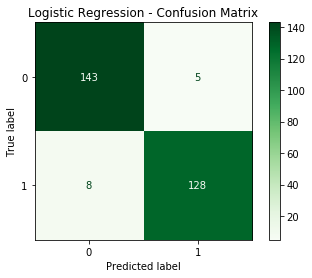

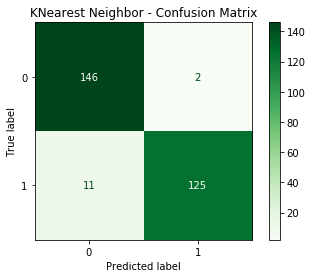

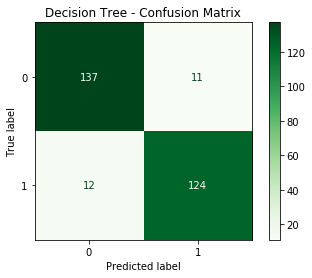

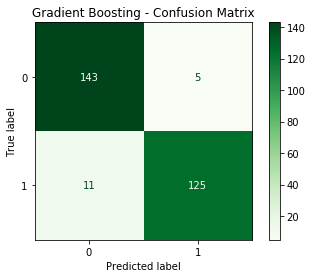

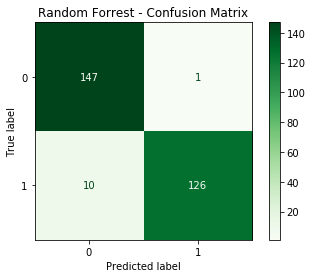

In [13]:
for key, classifier in classifiers.items():
    plot_confusion_matrix(classifier, X_test, y_test, cmap= 'Greens')
    plt.title(f'{key} - Confusion Matrix')
    plt.show()

Most of the models does a great job minimizing the number of False Positives which is important but not necessarily our main priority in this case. Interesting to see how Decision Tree had some of the best scores earlier, but seem to be one of the worst when looking at the Confusion Matrix. Proof that it is important to look at more than one measurement when evaluating the performance of a model. 

#### This series of Confusion Matrix is using all the data from the original dataset to see how effective the model really is

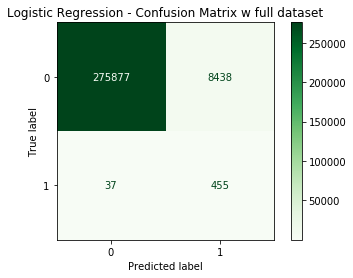

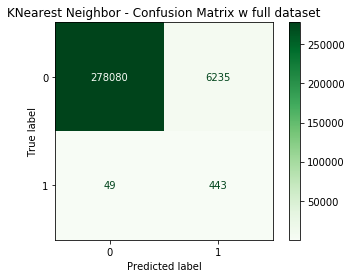

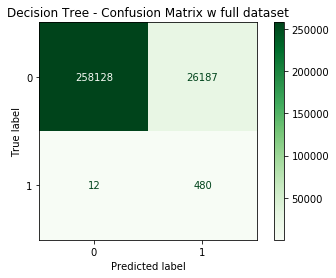

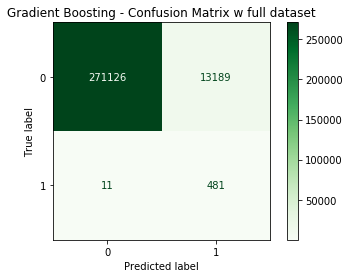

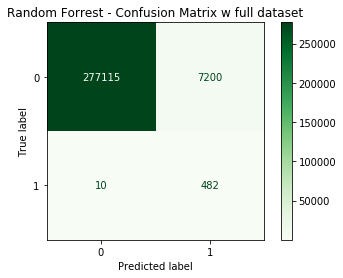

In [14]:
for key, classifier in classifiers.items():
    plot_confusion_matrix(classifier, x_variable_full, y_variable_full, cmap= 'Greens')
    plt.title(f'{key} - Confusion Matrix w full dataset')
    plt.show()

### Threshold
So that is it, the Random Forrest Classifier is the best model! Not quite yet, there is still one more thing we can do to improve the result and make it even better. By adjusting the probability threshold where the model predicts if the record is a Fraud (1) or non-Fraud (0). By default the threshold is set around 0.5, but the classifiers:
- Decision Tree
- Gradient Boosting 
- Random Forrest

All these models have a .predict_proba() method which gives you the probability of each record being 1 or 0. We can adjust this threshold to improve the model, based on our main goal. A lower threshold will predict more cases to be Fraud (1) so we might end up with lots of False Positives, while if we increase the threshold we can get rid of some of the False Negatives, since for the model to predict Fraud the probability has to be a lot higher.

In [19]:
# Setting threshold of probability
threshold = 0.56

predicted_proba = RandomForrest.predict_proba(x_variable_full)
predicted_full  = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_variable_full, predicted_full)
precision = precision_score(y_variable_full, predicted_full).round(4),
recall = recall_score(y_variable_full, predicted_full).round(4),
ROC = roc_auc_score(y_variable_full, predicted_full).round(4)

actual     = y_variable_full
prediction = predicted_full
result     = confusion_matrix(actual,prediction)

print(result)


[[279467   4848]
 [    11    481]]


### Precision-Recall Curve
The relationship between Precision and Recall is a little easier to see in visual representation, see graph below.

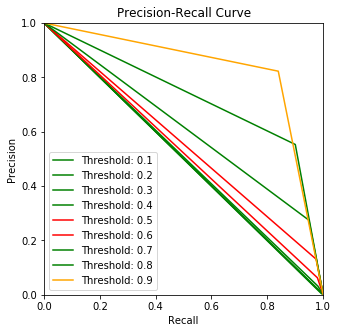

In [16]:
# Setting all thresholds
thresholds = [0.1,
              0.2,
              0.3,
              0.4,
              0.5,
              0.6,
              0.7,
              0.8,
              0.9]

colors = ['green','green','green',
                'green','red','red','green',
                'green','orange',]

# Plotting the graph 
plt.figure(figsize=(5,5))


for i,color in zip(thresholds,colors):
    
    y_test_pred_prob = predicted_proba[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_variable_full, 
                                                           y_test_pred_prob)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc=3)

## Final words
##### ~98% Recall score

Hardly the most advanced model in the world, but definitely effective detecting Fraud (1) transactions. Even though the Precision score is much lower than I would have wanted I managed to reduce the number of False Negatives, which in this case was the main goal. The model itself is very simple and cost-effective to run, which is a win in itself working with +280,000 records. 

The next thing I want to include in this project is to you under and oversampling methods like NearMiss() and SMOTE() which I know can be very effective on imbalanced datasets.

Stay tuned for more!